# HONGOS

In [1]:
%config IPCompleter.greedy=True

In [2]:
#Para omitir FutureWarning's en el resto del codigo
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
#paquete para tensores
import tensorflow as tf

In [4]:
#paquetes de siempre
import numpy as np
import pandas as pd

In [5]:
#paquetes para el analisis
import os                             
import skimage.io as im               #leer imagenes
import matplotlib.pyplot as plt
import random
import sklearn.model_selection as skl #train_test_split()
from skimage import transform         #reescalado
from skimage.color import rgb2gray    #escala de grises

## Cargar datos

In [6]:
#Directorio de trabajo
path = 'C:/Users/jvill/Documents/ESCUELA/Machine Learning/Datasets/Protocolo IA'

In [7]:
def cargar_datos(path):
    dirs = [d for d in os.listdir(path)
     if os.path.isdir(os.path.join(path,d))]

    labels = [] ; 
    images = []    

    for d in dirs:
        label_dir = os.path.join(path,d)
        file_names = [os.path.join(label_dir,f) 
                          for f in os.listdir(label_dir)]        
        for f in file_names:
            images.append(im.imread(f))    #Lee imagen 
            labels.append(d) #¿A qué carpeta pertenece la imagen?
            
    return images, labels

In [8]:
imagenes, etiquetas = cargar_datos(path)

In [9]:
#Se comprueba la carga
len(imagenes)  

412

In [10]:
imagenes[0].nbytes

4330560

Dividir las imagenes en 2 conjuntos Training - Testing 

(Proporciones recomendadas: 70-30,  75-25,  80-20)

Como se cuenta con pocas imágenes, primero se hará el análisis exploratorio para determinar si conviene o no dividir el dataset.

## Analisis exploratorio

In [11]:
#Numero de imagenes en el conjunto
num_img = len(imagenes)
num_eti = len(etiquetas)
if num_img==num_eti: print(num_img)

412


In [12]:
#Dimensiones de la primera imagen
first_shape = imagenes[0].shape
print(first_shape) 

(1040, 1388, 3)


In [13]:
#Corroborar misma dimension en todas las imagenes
for i in range(num_img):
    if imagenes[i].shape != first_shape:
        print('imagen', i,'diferente')  #Si hay alguna imagen de dimensiones diferentes, lo indicará

Todas las imagenes del dataset tienen el mismo tamaño, en este caso, *first_shape*

### Histograma de frecuencias de las especies

In [14]:
#Especies de hongos en el dataset
especies = set(etiquetas)
especies

{'Chrysosporium',
 'Microsporum canis',
 'Trichophyton mentagrophytes',
 'Trichophyton rubrum',
 'Trichophyton tonsurans'}

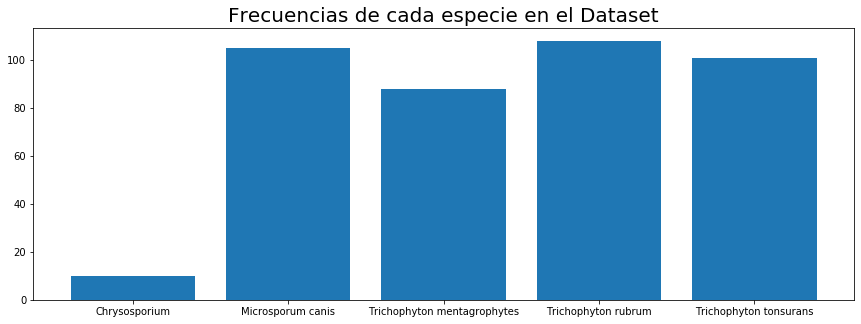

In [15]:
#Histograma de especies
frecuencias = np.unique(np.array(etiquetas),return_counts=True)
names = frecuencias[0]
values = frecuencias[1]
plt.figure(figsize=(50, 5))
plt.subplot(131)
plt.bar(names, values)
plt.title('Frecuencias de cada especie en el Dataset', size=20)
plt.show()

In [16]:
#Numero de fotos de cada especie
values

array([ 10, 105,  88, 108, 101], dtype=int64)

La especie Chrysosporium tiene muy pocos elementos, por lo tanto, no se dividirá el dataset en imagenes de entrenamiento e imagenes de evaluacion, ya que se podría perder demasiada información, quedándose con 7 u 8 imagenes para entrenar esa especie. En cambio, la validación al final se hará utilizando una muestra aleatoria del dataset.

Se considerará todo el conjunto como conjunto de entrenamiento.

In [17]:
#etiquetas_train,etiquetas_test,imagenes_train,imagenes_test = skl.train_test_split(etiquetas,imagenes, test_size = 0.2)

### Primera foto de cada especie

In [18]:
#Recordar el conjunto "especies"
especies

{'Chrysosporium',
 'Microsporum canis',
 'Trichophyton mentagrophytes',
 'Trichophyton rubrum',
 'Trichophyton tonsurans'}

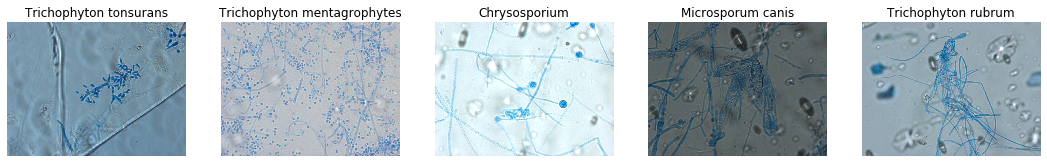

In [19]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp)
    
plt.show()
    

### 3 Fotos aleatorias de cada especie

In [20]:
#Funcion para obtener todos los indices de las fotos de cada especie
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

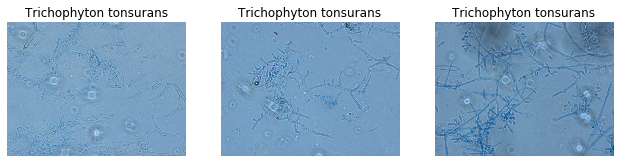

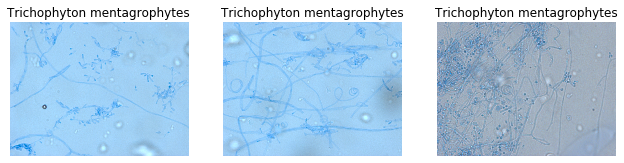

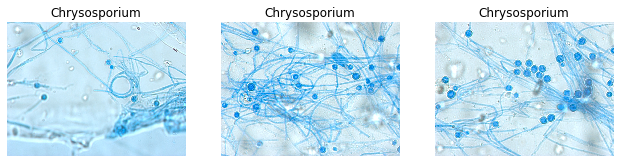

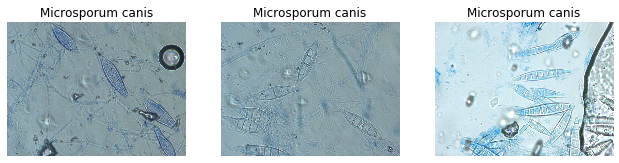

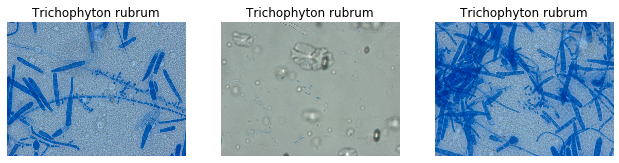

In [21]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]])
    plt.show()

## Tratamiento de imágenes

Resumen de la exploración anterior:
* Las imágenes son todas mismo tamaño *(1040, 1388, 3)*
* Hay 5 clases de imágenes *(Chrysosporium,Microsporum canis,Trichophyton mentagrophytes,Trichophyton rubrum,Trichophyton tonsurans)*
* La distribucion de especies no es uniforme y la especie *Chrysosporium* cuenta sólo 10 fotos

### Reescalado

En el caso de esta base de datos, se corroboró, en el análisis exploratorio, que todas las imágenes tienen las mismas dimensiones. No se presenta la necesidad de reescalar a todas las imágenes al mismo tamaño. Pero son demasiado grandes y se debe reducir su tamaño para el modelo de reconocimiento.

Después de muchas pruebas de tamaño para reescalar, se llegó a que un tamaño óptimo era 104x139 pxls

In [22]:
imagenes[0].shape #Dimension de las imagenes

(1040, 1388, 3)

In [23]:
imagenes[0].size

4330560

In [24]:
imagenes[0].nbytes

4330560

In [25]:
imagenes = [transform.resize(imagen,(104,139)) for imagen in imagenes] #transformacion

In [26]:
imagenes[0].shape #Nueva dimension de las imagenes

(104, 139, 3)

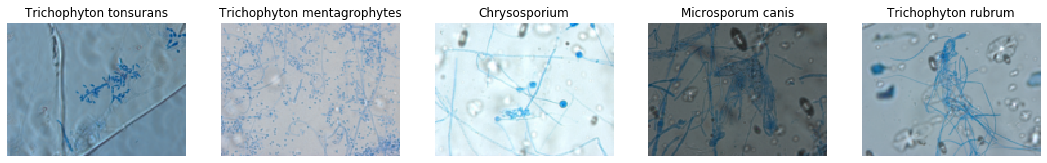

In [27]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp)
    
plt.show()
    

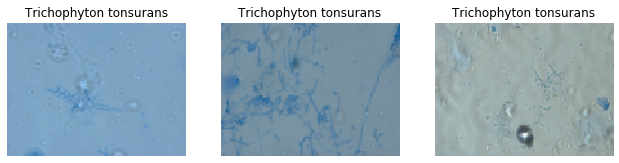

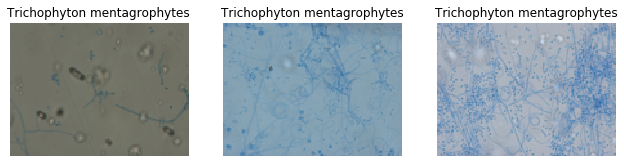

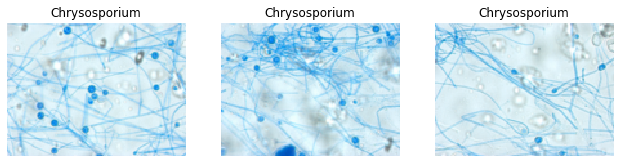

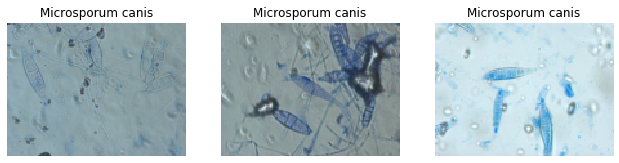

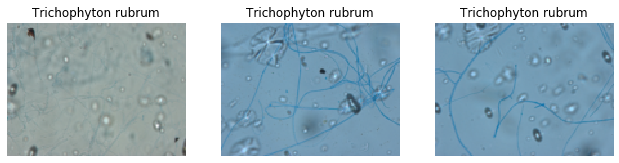

In [28]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]])
    plt.show()

### Colores a grises

In [29]:
imagenes[0]  #imagen en rgb

array([[[0.87058824, 0.92352941, 0.96470588],
        [0.87348709, 0.93034984, 0.96956552],
        [0.88039216, 0.94509804, 0.98431373],
        ...,
        [0.88417266, 0.94012555, 0.96848639],
        [0.9029835 , 0.94910425, 0.96180702],
        [0.88033573, 0.91366906, 0.93918747]],

       [[0.86666667, 0.92156863, 0.96271689],
        [0.87058824, 0.92941176, 0.97254902],
        [0.85686275, 0.93333333, 0.97345888],
        ...,
        [0.90090986, 0.96169417, 0.98823529],
        [0.88030752, 0.93623219, 0.96666667],
        [0.8627451 , 0.9254902 , 0.95490196]],

       [[0.86666667, 0.92253491, 0.96470588],
        [0.8745098 , 0.93333333, 0.97254902],
        [0.8627451 , 0.93816476, 0.97647059],
        ...,
        [0.89803922, 0.9627451 , 0.99215686],
        [0.89207222, 0.95089575, 0.98039216],
        [0.87252081, 0.93233883, 0.9617506 ]],

       ...,

       [[0.87843137, 0.93037805, 0.97058824],
        [0.88133023, 0.94509804, 0.98039216],
        [0.89019608, 0

In [30]:
imagenes = np.array(imagenes)  #Convierto la lista a arreglo
imagenes = rgb2gray(imagenes)  #Convierto las imagenes a escala de grises

In [31]:
imagenes[0] #imagen en grises

array([[0.91524824, 0.92109396, 0.93417549, ..., 0.93028038, 0.94021946,
        0.90842561],
       [0.91286875, 0.92002196, 0.91997639, ..., 0.95069112, 0.92654252,
        0.91427745],
       [0.91370344, 0.92366078, 0.92489993, ..., 0.95111569, 0.94052244,
        0.92174809],
       ...,
       [0.92223854, 0.93409209, 0.93981614, ..., 0.93270542, 0.93086469,
        0.92715678],
       [0.91306232, 0.9341575 , 0.93080451, ..., 0.92634653, 0.92090803,
        0.92198058],
       [0.91077216, 0.9079104 , 0.91761047, ..., 0.91860039, 0.91776706,
        0.92286896]])

In [32]:
imagenes[0].shape  

(104, 139)

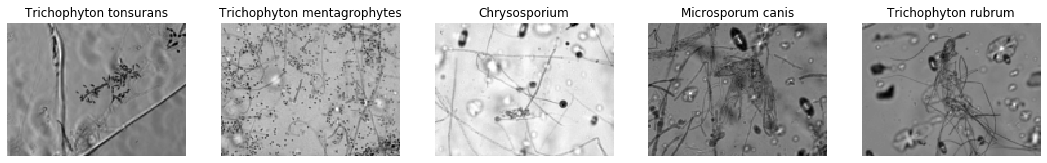

In [33]:
#Visualizar fotos de especies
plt.figure(figsize=(30,30))
i=1
for especie in especies:
    img_temp = imagenes[etiquetas.index(especie)] #index arroja sólo el primer indice que contiene 'especie'
    plt.subplot(8,8,i)
    plt.axis("off")
    plt.title(especie)#+' ('+str(etiquetas.count(especie))+')')    
    i+=1
    plt.imshow(img_temp, cmap = 'gray')
    
plt.show()
    

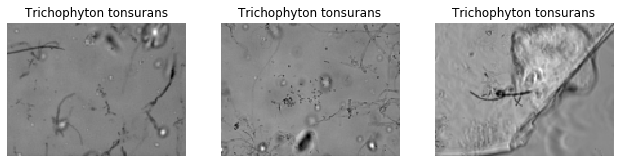

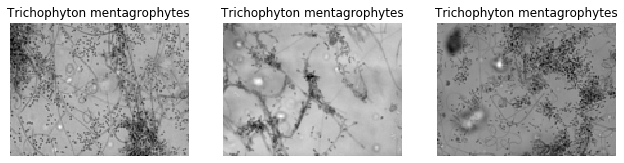

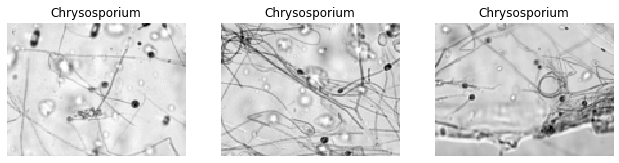

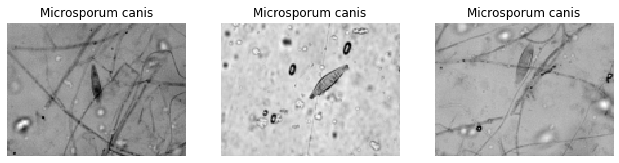

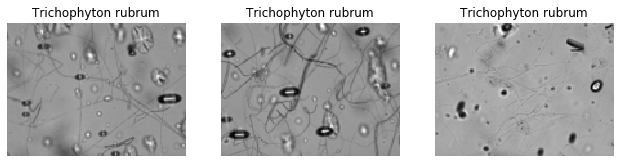

In [34]:
for especie in especies:
    indices = random.sample(get_indexes(especie,etiquetas),3) #muestra aleatoria de 3 indices
    plt.figure(figsize=(30,30))
    
    for i in range(3):
        plt.subplot(8,8,i+1)
        plt.axis("off")
        plt.title(especie) 
        plt.imshow(imagenes[indices[i]],cmap='gray')
    plt.show()

## Modelo de Red Neuronal

## Preparar dataset

In [35]:
dado=np.asarray([2,3,4])
dado.ndim

1

In [36]:
imagenes.shape

(412, 104, 139)

In [37]:
n = imagenes.shape[0]  #num de individuos
p = imagenes.shape[1]*imagenes.shape[2]    #num de features

In [38]:
X = []
contador = 0
for i in imagenes:
    X.append(i.flatten().tolist())
    contador+=1
X = np.asarray(X)

In [39]:
long_imagen = len(X[0])

In [40]:
def asignar_vector(x):
    return {
        'Chrysosporium': [1,0,0,0,0],
        'Microsporum canis': [0,1,0,0,0],
        'Trichophyton mentagrophytes': [0,0,1,0,0],
        'Trichophyton rubrum': [0,0,0,1,0],
        'Trichophyton tonsurans': [0,0,0,0,1],
    }[x]

In [41]:
Y = []
for eti in etiquetas:
    Y.append(asignar_vector(eti))
Y = np.asarray(Y)

In [42]:
#Conjunto para validación
muestra = np.random.randn(n)
X_test = []
Y_test = []
c=0
for index, m in enumerate(muestra):
    if m>0.85:
        X_test.append(X[index])
        Y_test.append(Y[index])

## Grafo 

In [43]:
#paquete para capas y regresión
import tflearn
from tflearn import DNN
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

curses is not supported on this machine (please install/reinstall curses for an optimal experience)








In [44]:
#Construyendo perceptrón
input_layer = tflearn.input_data(shape=[None, long_imagen])
dense1 = tflearn.fully_connected(input_layer, 64, activation='tanh',
                                 regularizer='L2', weight_decay=0.001)
dropout1 = tflearn.dropout(dense1, 0.8)
dense2 = tflearn.fully_connected(dropout1, 64, activation='tanh',
                                 regularizer='L2', weight_decay=0.001)
dropout2 = tflearn.dropout(dense2, 0.8)
softmax = tflearn.fully_connected(dropout2, 5, activation='softmax')

# Regression using SGD with learning rate decay and Top-3 accuracy
# Regresión usando descenso del gradiente con disminución de la tasa de aprendizaje y precisión Top-3
sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.96, decay_step=1000)
top_k = tflearn.metrics.Top_k(3)
net = tflearn.regression(softmax, optimizer=sgd, metric=top_k,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X, Y, n_epoch=10, validation_set=(X_test, Y_test),
          show_metric=True, run_id="dense_model")

Training Step: 69  | total loss: 1.46719 | time: 0.200s
| SGD | epoch: 010 | loss: 1.46719 - top3: 0.7608 -- iter: 384/412
Training Step: 70  | total loss: 1.46100 | time: 1.233s
| SGD | epoch: 010 | loss: 1.46100 - top3: 0.7686 | val_loss: 1.42961 - val_acc: 0.8293 -- iter: 412/412
--
